# Excitation Generation via Intrinsic Mode Function

This method is primarily inspired by adaptive decomposition algorithms in signal processing. For the first few methods, the excitation time series sampled from a mixed distribution exhibit strong randomness.
The excitation time series sampled from an ARMA($p$, $q$) model primarily reflect the continuity and temporal dependencies of time series data (mainly in terms of trend characteristics).
In contrast, time series generated by methods such as ForecastPFN and KernelSynth incorporate both trend and periodic characteristics of time series.
Therefore, to specifically capture the periodicity of time series data, we generate excitation time series data based on the perspective of intrinsic mode functions, leveraging the [`PySDKit`](https://github.com/wwhenxuan/PySDKit) project.

**About Signal Decomposition**: Since the introduction of the **Hilbert-Huang Transform** in 1998, signal decomposition have become one of the most effective **time-frequency analysis** techniques in the 21st century.
These methods adaptively decompose a signal or time series through iterative processes in the time domain and filtering in the frequency domain,
thereby overcoming the limitations of Fourier transform in handling non-linear and non-stationary signals,
as well as the issue of basis function selection in wavelet transform.
In signal decomposition, the resulting sub-signals with specific amplitudes and frequencies are referred to as **Intrinsic Mode Functions (IMFs)**,
which are amplitude-modulated-frequency-modulated (AM-FM) signals, expressed as:
$$
u_k(t) = A_k (t) \mathrm{cos}(\phi_k (t) ),
$$
where, the phase $\phi_k (t)$ is a non-decreasing function, $\phi_k'(t) \ge 0$, the envelope is non-negative $A_k(t) \ge 0$, and, very importantly, both the envelope $A_k (t)$ and the instantaneous frequency $\omega_{k} (t) := \phi_{k}' (t)$ vary much slower than the phase $\phi_k (t)$.

It is generally believed that a complex signal in the real world is often composed of multiple Intrinsic Mode Functions (IMFs). When dealing with real physical systems, it is often necessary to extract and analyze a specific IMF, which requires the use of signal decomposition algorithms.

Signal decomposition algorithms are mainly divided into time-domain iterative methods, such as Empirical Mode Decomposition (EMD) and its variants, and frequency-domain filtering methods, such as Empirical Wavelet Transform (EWT) and Variational Mode Decomposition (VMD). We have integrated EMD, STL, and VMD algorithms into S2Generator. If you are interested in adaptive signal decomposition, you may want to explore another project we developed: [`PySDKit`](https://github.com/wwhenxuan/PySDKit).

Currently, the majority of scholars in the signal processing field use MATLAB as their primary programming language, while Python dominates the machine learning and deep learning platforms. This discrepancy has prevented many advanced signal decomposition algorithms from being effectively integrated with deep learning techniques. To address this issue, we developed [`PySDKit`](https://github.com/wwhenxuan/PySDKit), which is designed to facilitate direct algorithm invocation and promote the advancement of time series analysis from the perspective of signal processing.

In this method, we consider the time series $y(t)$ as a combination of multiple different intrinsic mode functions $u_k(t)$ and the gaussian noise sequence $\epsilon \sim \mathcal{N}(0, 1)$.
These eigenmodes can be sine and cosine signals, amplitude modulated (AM) signals, sawtooth wave signals, and other signals.
We first determine the number of signals to use and then generate the corresponding intrinsic mode functions and their weights:

$$
y(t) = \sum_{k} w_k \times u_k(t) + \epsilon,
$$
where, $w_k$ is the random weight for the IMFs $u_k (t)$ and is normalized by $\sum_{k} w_k = 1$.


In [3]:
import numpy as np
from matplotlib import pyplot as plt
from S2Generator.excitation import IntrinsicModeFunction

# Create the instance for IntrinsicModeFunction
imfs = IntrinsicModeFunction(
    min_base_imfs=2,  # From the perspective of Fourier expansion, sine and cosine signals are the most basic signals
    max_base_imfs=4,  # Therefore, we will select 2~4 sine and cosine signals as the base for this stimulus generation.
    min_choice_imfs=1,  # We will then select a number of different random signals
    max_choice_imfs=5,
    probability_dict=None,  # We set aside a dictionary to control the probability of each signal being used
    min_duration=0.5,
    max_duration=10.0,  # The maximum signal duration in seconds
    min_amplitude=0.01,
    max_amplitude=10.0,  # The maximum amplitude for generated signal components
    min_frequency=0.01,
    max_frequency=8.0,  # The maximum frequency for signal components (Hz)
    noise_level=0.1,  # Amplitude of Gaussian noise to add (relative to signal amplitude)
)  # For most cases, using the default parameters to generate the stimulus signal is sufficient for most situations

# Create the random number generator
rng = np.random.RandomState(42)

# Generate the excitation through `generate` method
time_series = imfs.generate(rng=rng, input_dimension=1, n_inputs_points=512)

print(
    f"The Excitation Method: {str(imfs)} and Generate the Time Series Data with Shape: {time_series.shape}"
)

The Excitation Method: IntrinsicModeFunction and Generate the Time Series Data with Shape: (512, 1)


The probability dict: 
 {'generate_sin_signal': 0.3, 'generate_cos_signal': 0.3, 'generate_am_signal': 0.2, 'generate_sawtooth_wave': 0.2}


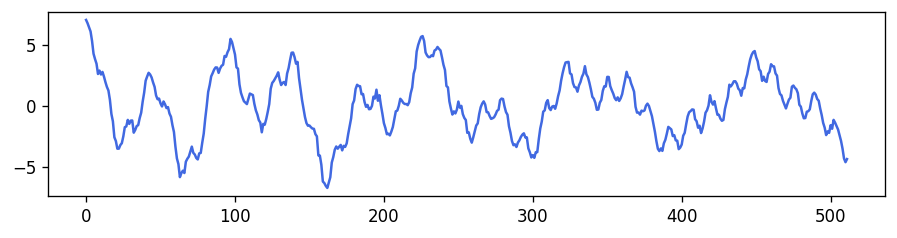

In [4]:
# Visualization for the excitation
fig, ax = plt.subplots(figsize=(9, 2), dpi=120)

ax.plot(time_series, color="royalblue")

# We can check the probability dict
print("The probability dict: \n", imfs.available_dict)

To prevent numerical explosion in the generated excitation time series data, we can randomly scale the intrinsic mode function (IMF) within a specified range by calculating its "energy" during the data generation process.
For a time series of length $n$, its energy $E$ can be represented by its second norm:
$$
E = \frac{1}{n} \left \| y(t) \right \| ^ 2 = \frac{1}{n} \sum_{i} ^ {n} y(i) ^ 2.
$$

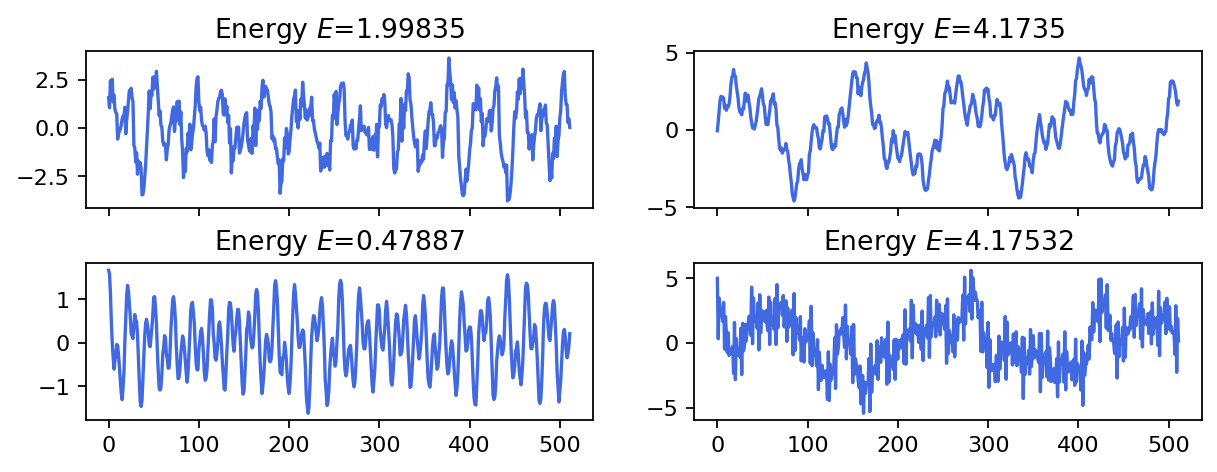

In [5]:
# We set the maximum energy range when creating a new instance
imfs = IntrinsicModeFunction(
    upper_energy=24,  # Set the upper energy
    noise_level=0.1,
)

# Generate the multi-channels time series
time_series = imfs.generate(rng=rng, input_dimension=4, n_inputs_points=512)

# Visualization for the excitation
fig, ax = plt.subplots(2, 2, figsize=(9, 3), dpi=160, sharex=True)
fig.subplots_adjust(hspace=0.35)

for i in range(2):
    for j in range(2):
        ax[i][j].plot(time_series[:, i * 2 + j], color="royalblue")
        ax[i][j].set_title(
            f"Energy $E$={np.round(np.mean(time_series[:, i * 2 + j] ** 2), 5)}"
        )

We can further examine the fundamental forms of these sub-signals in the frequency domain.
We can simply examine the real part of the Fast Fourier Transform (FFT) result.
We can see that several major frequency components are sub-signals that make up the excitation time series, namely, the intrinsic mode functions (IMFs).

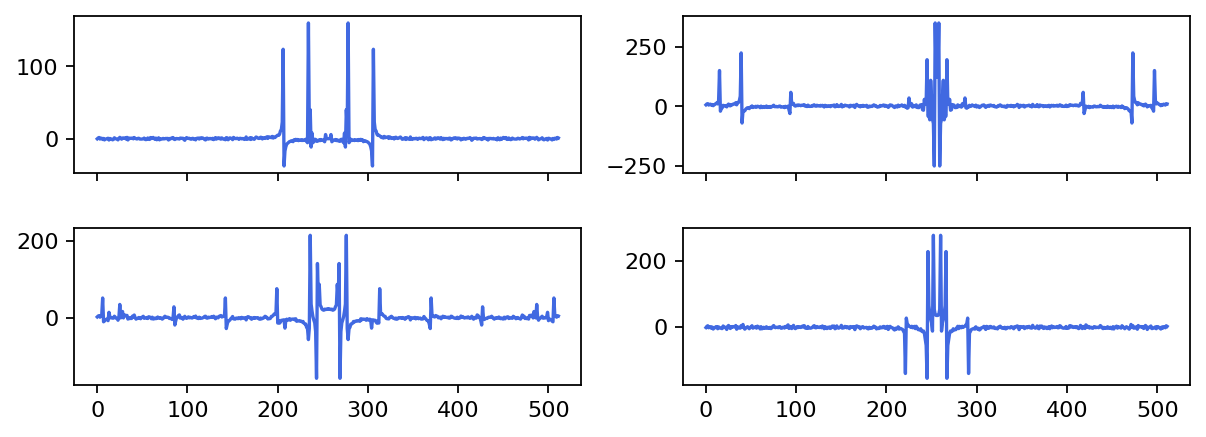

In [6]:
from S2Generator.utils import fft, fftshift

# Implementing Fast Fourier Transform
freq = fftshift(fft(time_series))

# Visualize the results in the frequency domain
fig, ax = plt.subplots(2, 2, figsize=(9, 3), dpi=160, sharex=True)

for i in range(2):
    for j in range(2):
        ax[i][j].plot(np.real(freq[:, i * 2 + j]), color="royalblue")

We can use an adaptive signal decomposition algorithm to observe the different intrinsic mode functions that make up the excitations of this time series data.

We can directly import the [`variational mode decomposition (VMD)`](https://github.com/wwhenxuan/PySDKit/blob/main/pysdkit/_vmd/vmd_c.py) algorithm, the most commonly used in adaptive mode decomposition, from PySDKit and use the [`plot_IMFs`](https://github.com/wwhenxuan/PySDKit/blob/main/pysdkit/plot/_plot_imfs.py) method to visualize the decomposed sub-signals.

Here, we use the first signal as an example. Because the amplitude spectrum is symmetrical, we can clearly see that the signal has three main frequency components, with the remaining minor fluctuations being amplitude.
For this reason, we set the number of modes to be decomposed to 4.

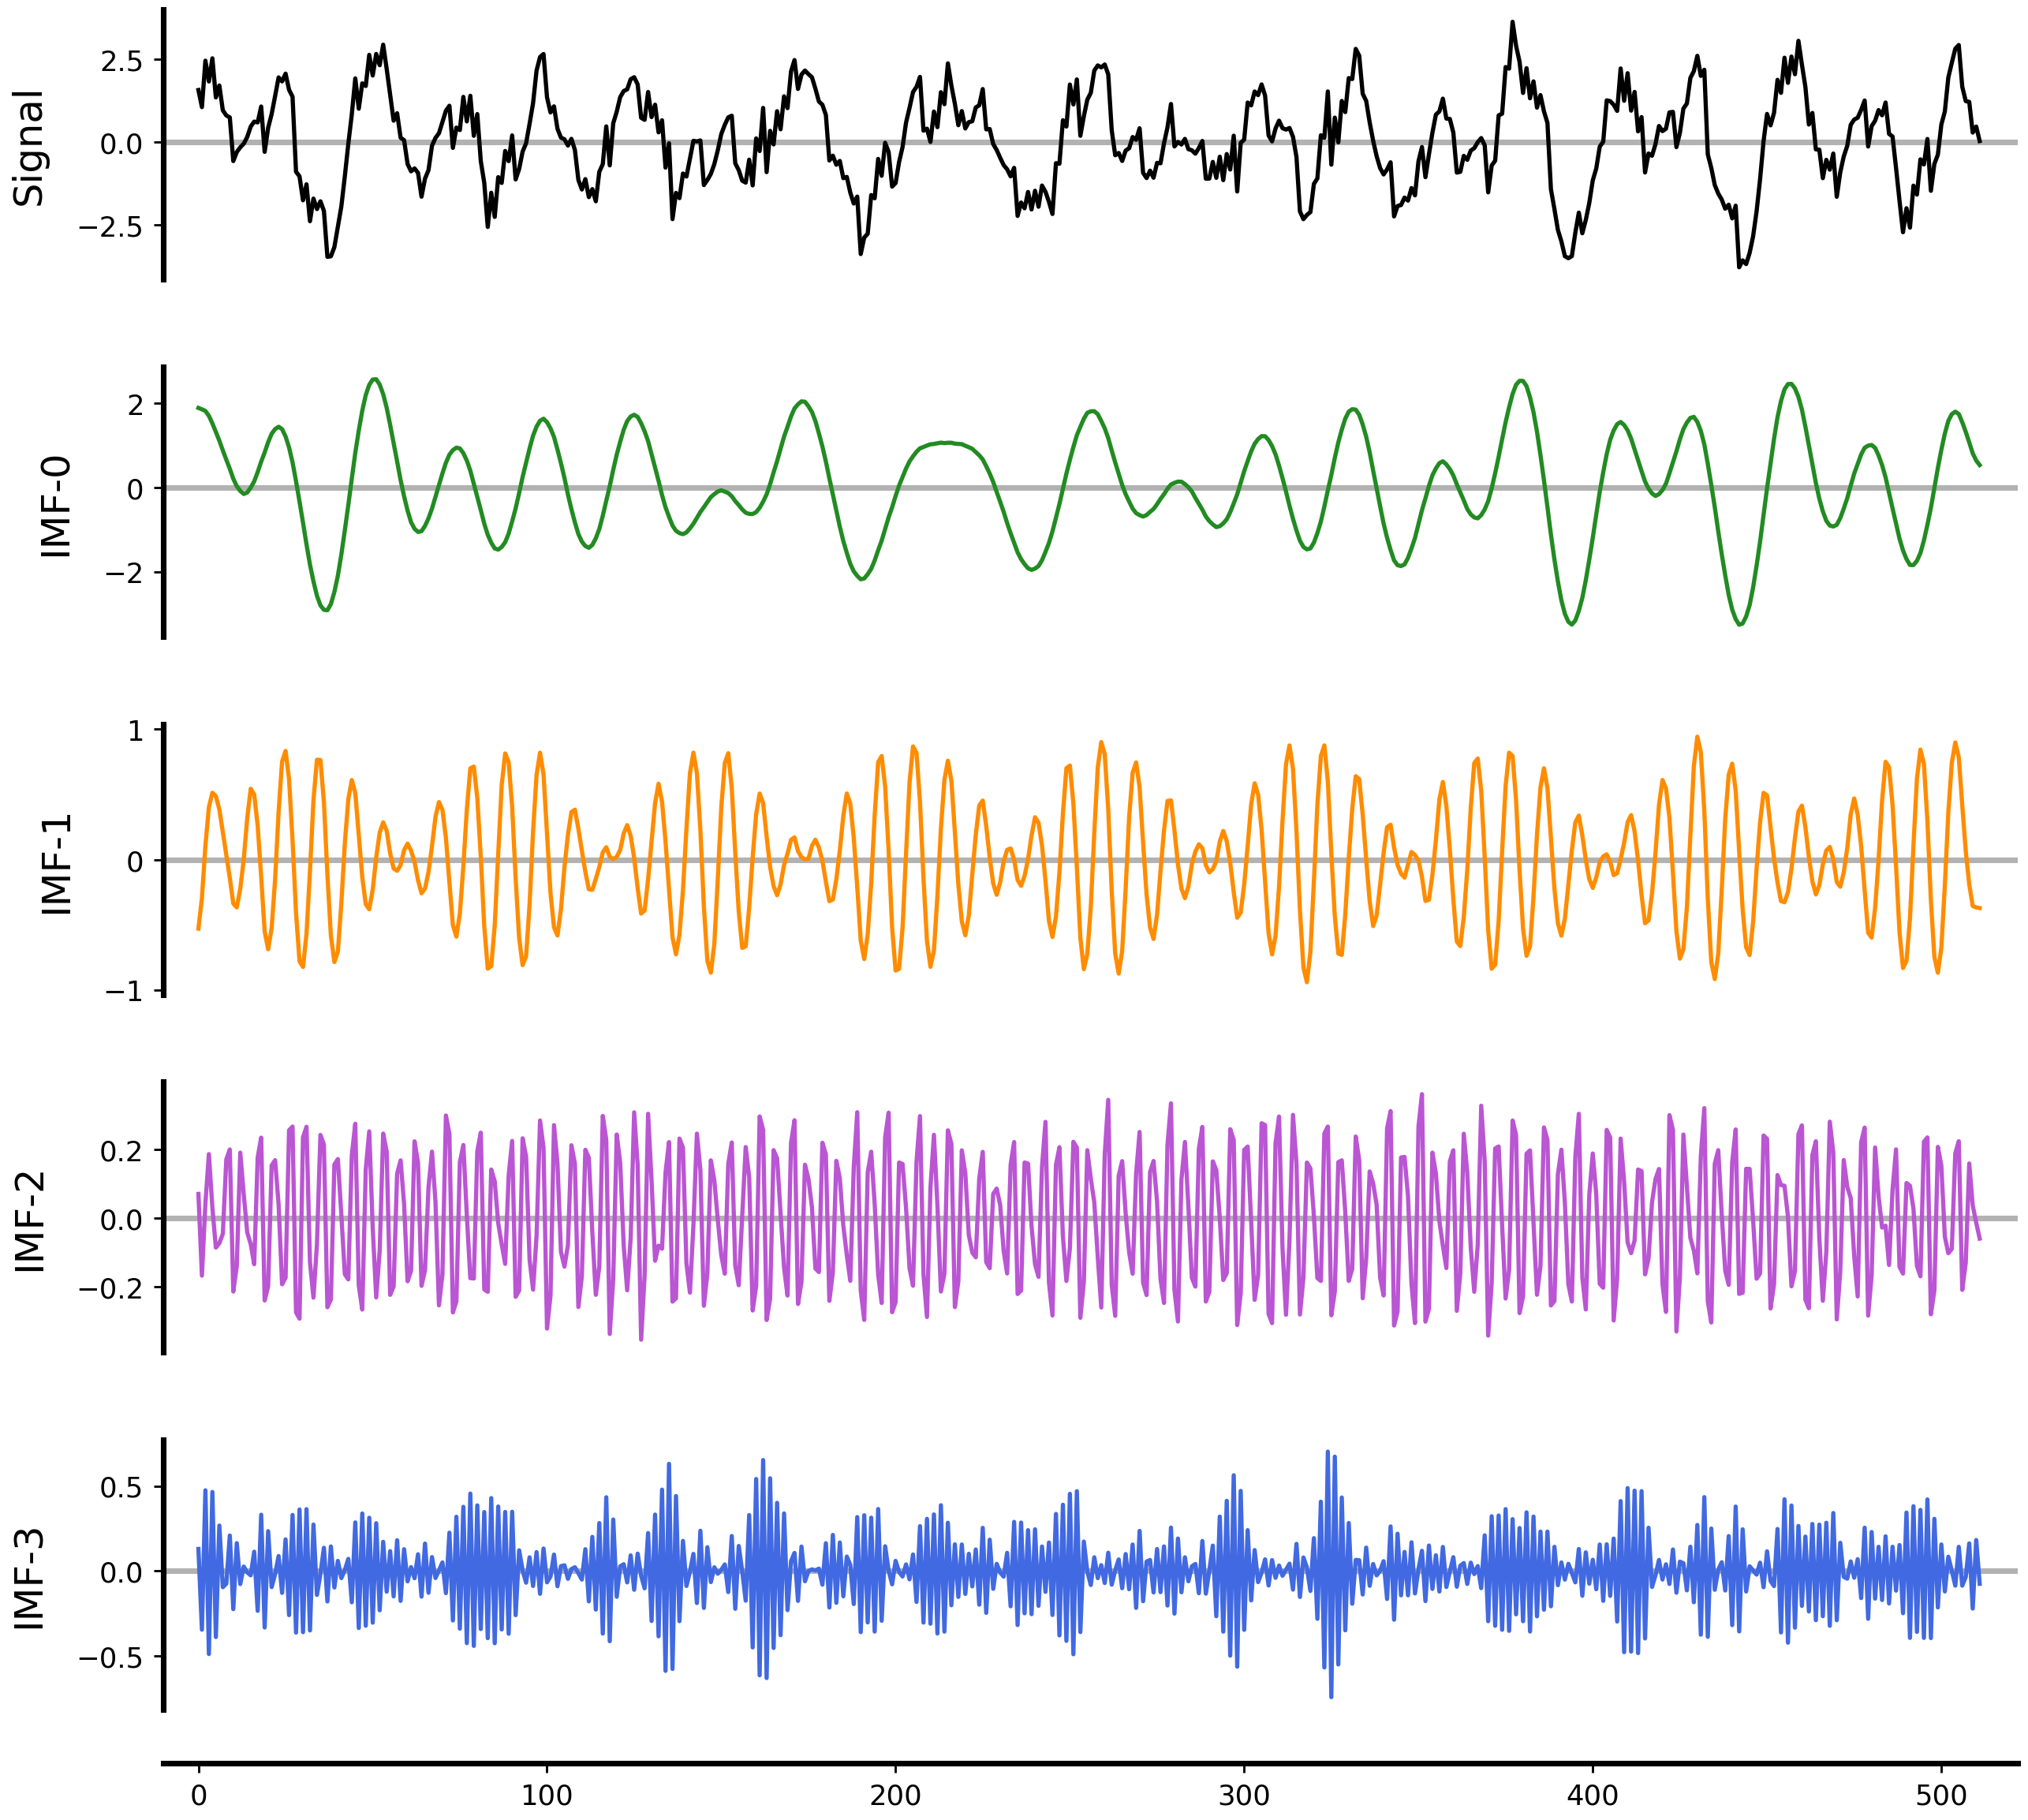

In [11]:
from pysdkit import VMD
from pysdkit.plot import plot_IMFs

# Creating an instance of the algorithm for signal decomposition
vmd = VMD(K=4, alpha=500, tau=0.1)

# Calling the variational mode decomposition algorithm
imfs_results = vmd.fit_transform(signal=time_series[:, 0])

# Visualize the decomposition results
fig = plot_IMFs(signal=time_series[:, 0], IMFs=imfs_results)